In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn


In [67]:
gpu_name = torch.cuda.get_device_name()
gpu_name

'NVIDIA GeForce RTX 3060'

In [68]:
gpu = torch.device("cuda")

In [69]:
train_dataset = datasets.MNIST(root="/home/bankai/Documents/Machine-Learning/Datasets", train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root="/home/bankai/Documents/Machine-Learning/Datasets", train=False, download=True, transform=transforms.ToTensor())

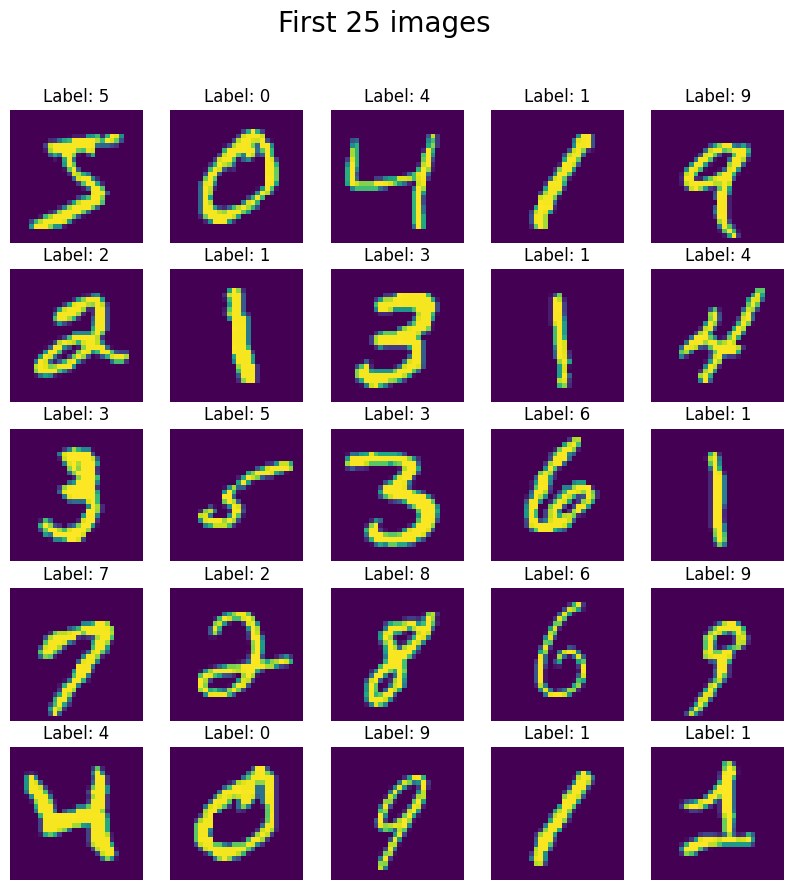

In [70]:
fig, axes = plt.subplots(5, 5, figsize=(10,10))
plt.suptitle("First 25 images", fontsize=20)

for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze())
    ax.set_title(f"Label: {str(label)}")
    ax.axis(False)

In [102]:
x_train = train_dataset.data.reshape(60000,784)
y_train = train_dataset.targets
x_test = test_dataset.data.reshape(10000,784)
y_test = test_dataset.targets


In [103]:
x_train = x_train/255.0
x_test = x_test/255.0


In [104]:
class CustomDataset(Dataset):

    def __init__(self, features, labels):
        self.features = features.detach().clone()
        self.labels = labels.detach().clone()
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [105]:
train_tensor = CustomDataset(x_train, y_train)
test_tensor = CustomDataset(x_test, y_test)

In [106]:
train_dataloader = DataLoader(train_tensor, batch_size=256, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_tensor, batch_size=256, shuffle=False, pin_memory=True)

In [107]:
class MNIST_NN(nn.Module):

    def __init__(self, num_features):

        super().__init__()

        self.model = nn.Sequential(

            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10)

        )

    def forward(self, x):
        return self.model(x)

In [108]:
learning_rate = 0.1
epochs = 100

In [109]:
model = MNIST_NN(x_train.shape[1])
model = model.to(gpu)
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

loss_function = nn.CrossEntropyLoss()

In [112]:
for epoch in range(epochs):

    total_epoch_loss = 0

    for batch_features, batch_labels in train_dataloader:

        batch_features = batch_features.to(gpu)
        batch_labels = batch_labels.to(gpu)

        output = model.forward(batch_features)
        

        loss = loss_function(output, batch_labels)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        total_epoch_loss = total_epoch_loss + loss.item()
    
    avg_loss = total_epoch_loss/len(train_dataloader)

    print(f"Epoch: {epoch + 1}, Loss: {avg_loss}")

Epoch: 1, Loss: 0.0008001546110422846
Epoch: 2, Loss: 0.0007870594660028261
Epoch: 3, Loss: 0.000780960070427527
Epoch: 4, Loss: 0.0007694068052706883
Epoch: 5, Loss: 0.0007580418161988417
Epoch: 6, Loss: 0.0007491808477541472
Epoch: 7, Loss: 0.0007392745868778451
Epoch: 8, Loss: 0.000732972881660123
Epoch: 9, Loss: 0.0007218134743062423
Epoch: 10, Loss: 0.0007121408574946938
Epoch: 11, Loss: 0.0007068693101594343
Epoch: 12, Loss: 0.0006956499484813514
Epoch: 13, Loss: 0.0006888117634399021
Epoch: 14, Loss: 0.0006797820323473833
Epoch: 15, Loss: 0.0006726737022697133
Epoch: 16, Loss: 0.0006658399576677921
Epoch: 17, Loss: 0.0006594099743450259
Epoch: 18, Loss: 0.0006493987374384194
Epoch: 19, Loss: 0.0006449743440285563
Epoch: 20, Loss: 0.000639102526227052
Epoch: 21, Loss: 0.0006287359515517118
Epoch: 22, Loss: 0.0006259252086276822
Epoch: 23, Loss: 0.0006187600125756828
Epoch: 24, Loss: 0.0006130389952809213
Epoch: 25, Loss: 0.0006045860284815563
Epoch: 26, Loss: 0.000599405174812381

In [143]:
with torch.no_grad():

    all_predicted = []
    all_labels = []

    for batch_features, batch_labels in test_dataloader:

        batch_features = batch_features.to(gpu)
        batch_labels = batch_labels.to(gpu)

        output = model.forward(batch_features)

        _, y_predict = torch.max(output, 1)

        all_predicted.extend(y_predict.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())



Text(158.22222222222223, 0.5, 'Actual')

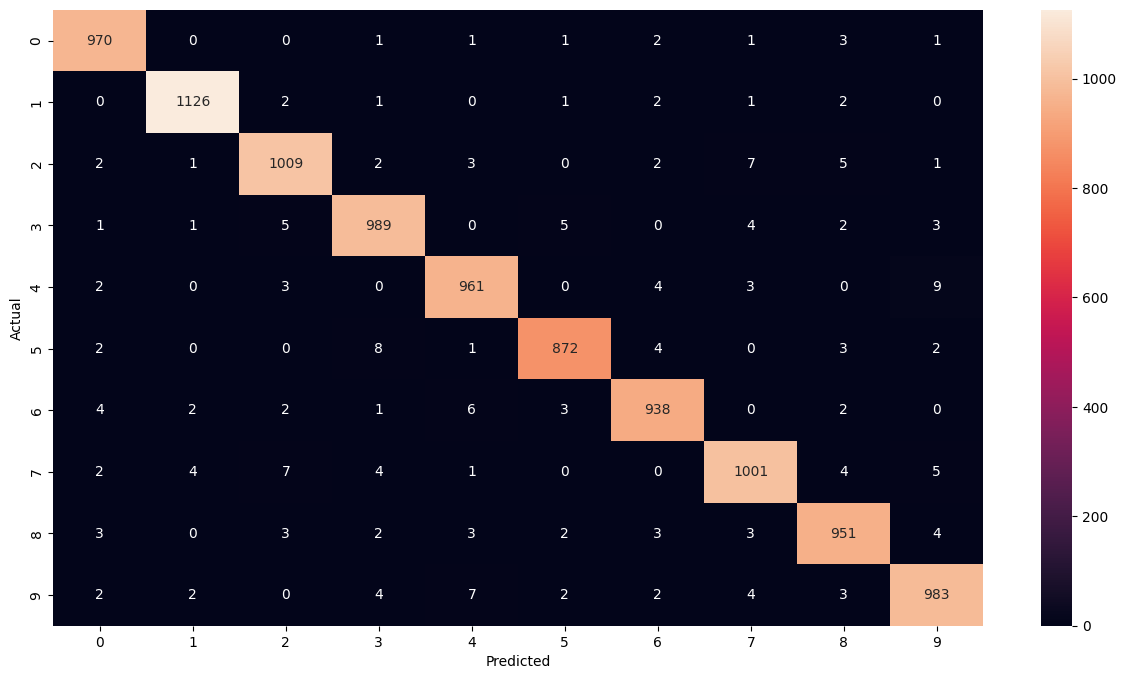

In [145]:
cm = confusion_matrix(all_labels, all_predicted)
plt.figure(figsize=(15, 8))
sn.heatmap(cm, fmt='d', annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")


In [133]:
accuracy = accuracy_score(all_labels, all_predicted)
accuracy

0.98